In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

In [3]:
file_path = 'traffic.csv'
traffic_data = pd.read_csv(file_path)

In [4]:
def clean_data(df):
    # Handle missing values
    df.fillna(method='ffill', inplace=True)  # Forward fill missing values

    # Convert DateTime to datetime type
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Handle outliers in Vehicles column
    df = df[df['Vehicles'] < df['Vehicles'].quantile(0.99)]

    return df

cleaned_traffic_data = clean_data(traffic_data)

In [6]:
def wrangle_data(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid chained assignment

    # Extract hour, day, and month from DateTime
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['date'] = df['DateTime'].dt.date

    return df

wrangled_traffic_data = wrangle_data(cleaned_traffic_data)


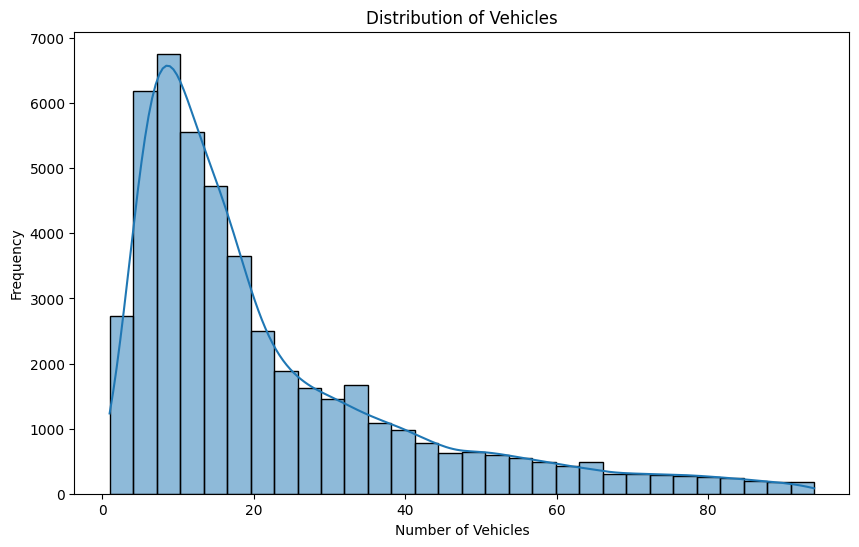

<ipython-input-9-b8e5bc48c874>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='hour', y='Vehicles', data=wrangled_traffic_data, ci=None)


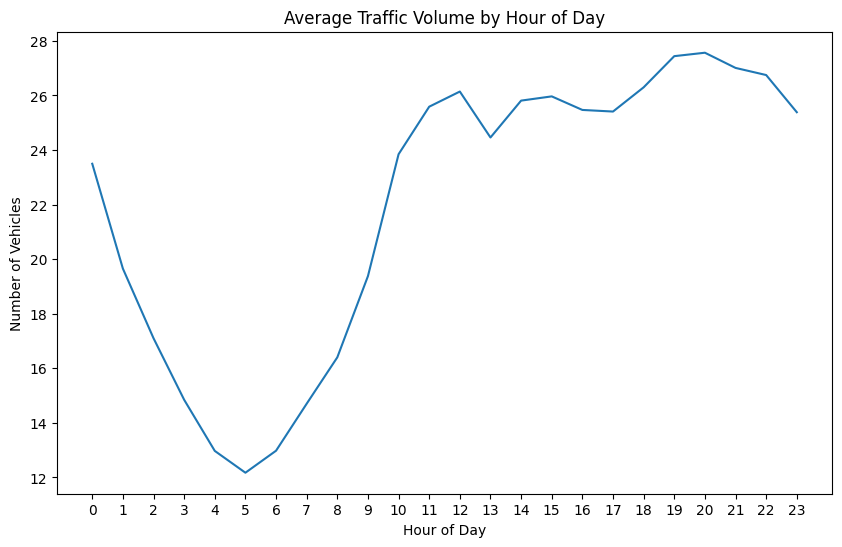

<ipython-input-9-b8e5bc48c874>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='Vehicles', data=wrangled_traffic_data, ci=None)


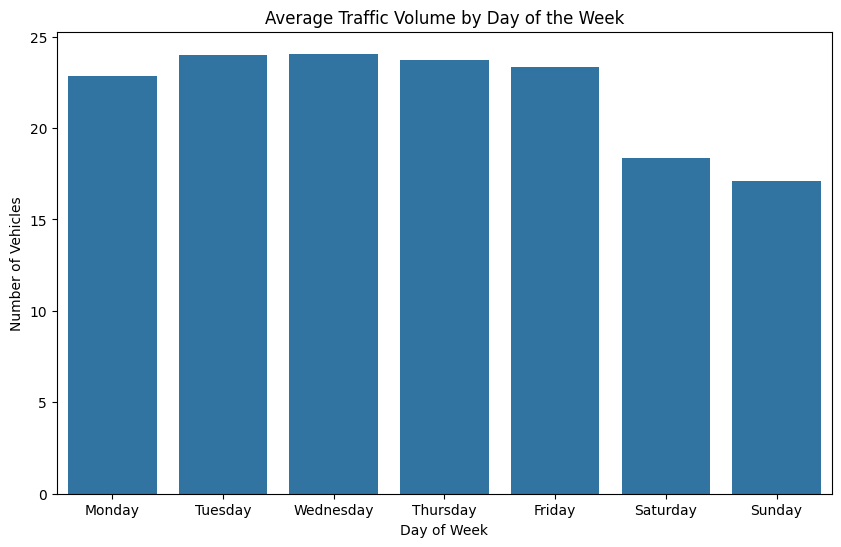

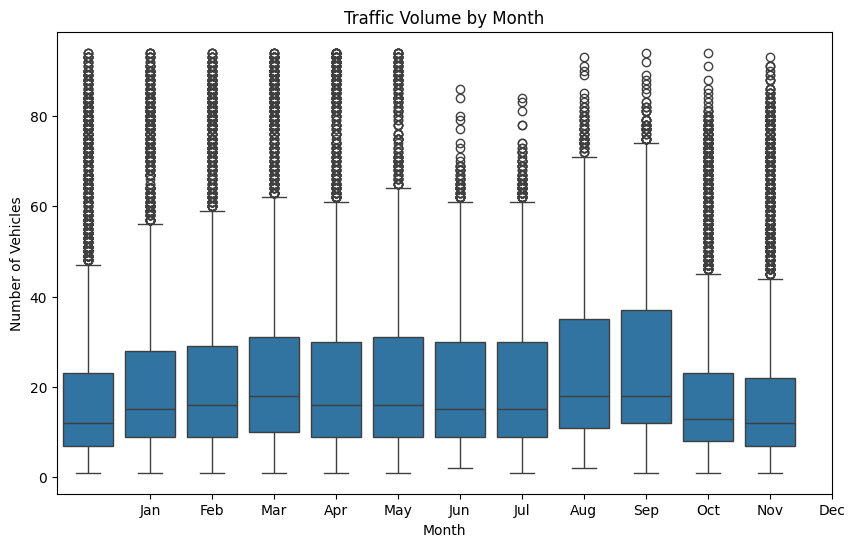

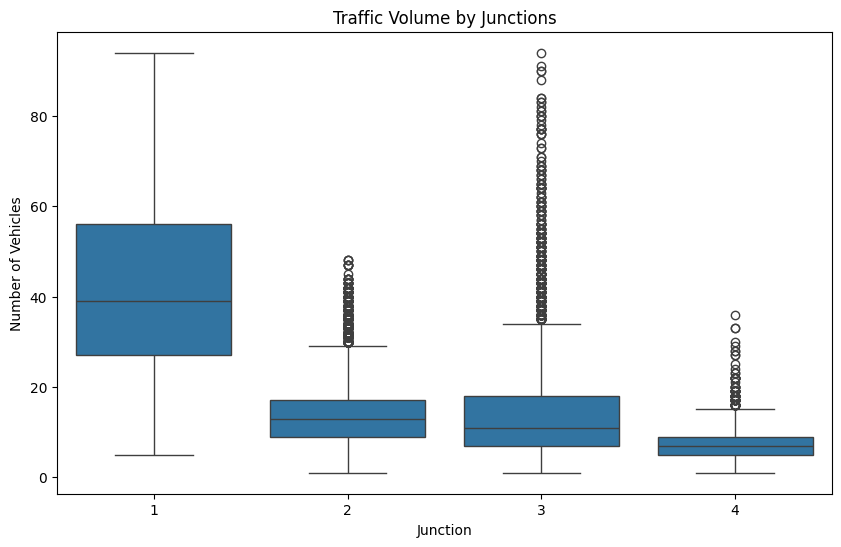

Peak Hours of Traffic:
hour
20    27.567540
19    27.441645
21    27.010644
Name: Vehicles, dtype: float64


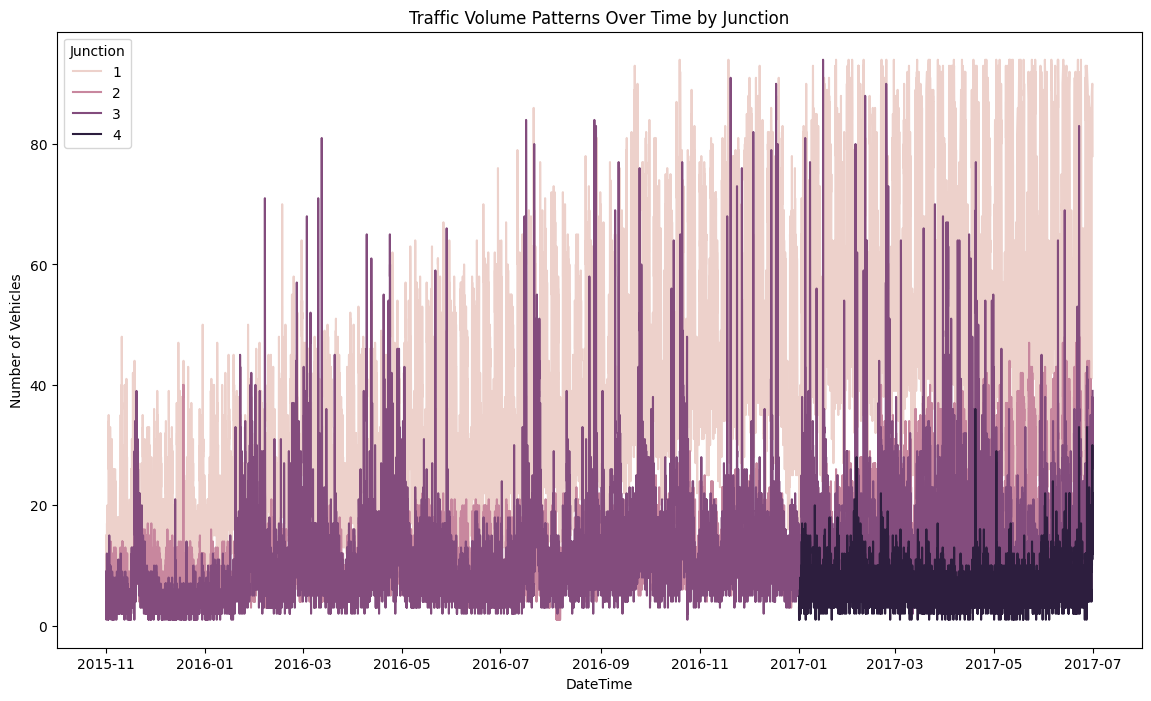

<ipython-input-9-b8e5bc48c874>:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='month', y='Vehicles', data=wrangled_traffic_data, ci=None)


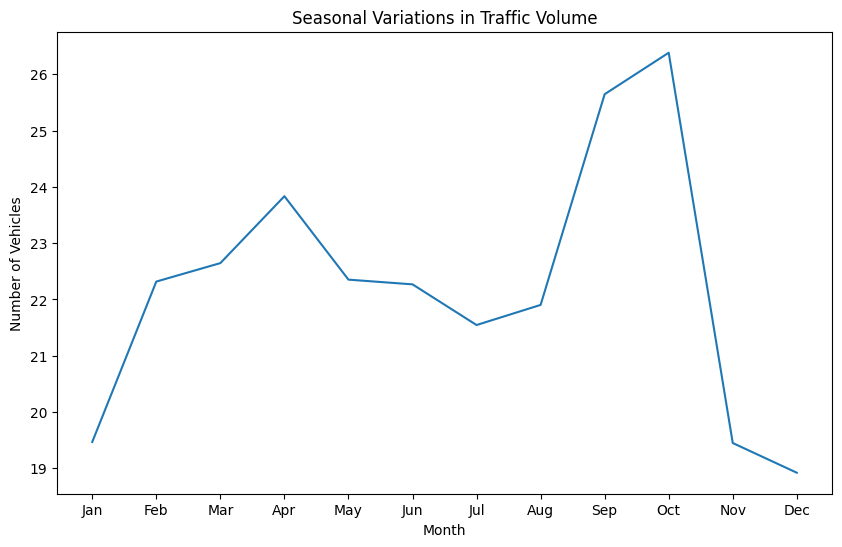

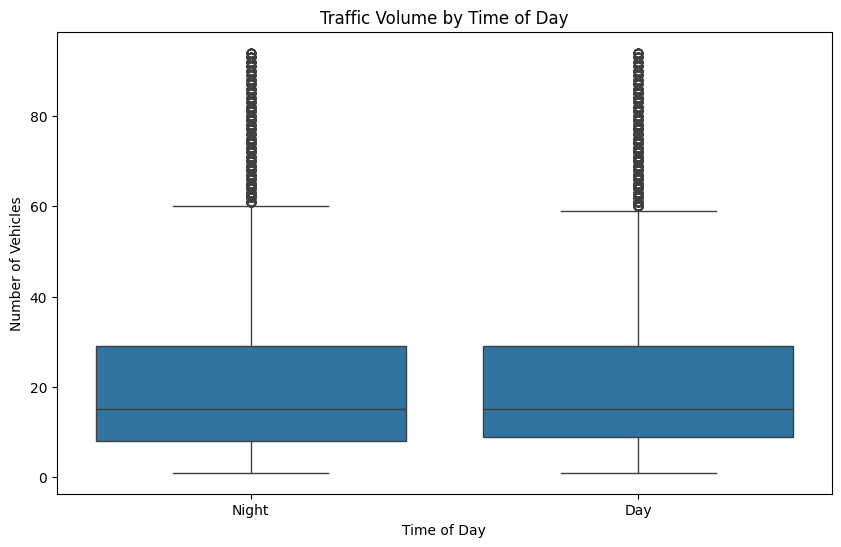

In [9]:
# 3.1: Visualize distribution of Vehicles
plt.figure(figsize=(10, 6))
sns.histplot(wrangled_traffic_data['Vehicles'], bins=30, kde=True)
plt.title('Distribution of Vehicles')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()

# 3.2: Average traffic volume by hour of day
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='Vehicles', data=wrangled_traffic_data, ci=None)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Vehicles')
plt.xticks(np.arange(0, 24, step=1))
plt.show()

# 3.3: Average traffic volume by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='Vehicles', data=wrangled_traffic_data, ci=None)
plt.title('Average Traffic Volume by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Vehicles')
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

# 3.4: Average traffic volume by month
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='Vehicles', data=wrangled_traffic_data)
plt.title('Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Number of Vehicles')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# 3.5: Traffic volume by junctions
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=wrangled_traffic_data)
plt.title('Traffic Volume by Junctions')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

# 3.6: Analyze peak hours of traffic
peak_hours = wrangled_traffic_data.groupby('hour')['Vehicles'].mean().sort_values(ascending=False).head(3)
print("Peak Hours of Traffic:")
print(peak_hours)

# 3.7: Explore traffic volume patterns over different junctions
plt.figure(figsize=(14, 8))
sns.lineplot(x='DateTime', y='Vehicles', hue='Junction', data=wrangled_traffic_data)
plt.title('Traffic Volume Patterns Over Time by Junction')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend(title='Junction')
plt.show()

# 3.8: Analyze seasonal variations in traffic volume
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='Vehicles', data=wrangled_traffic_data, ci=None)
plt.title('Seasonal Variations in Traffic Volume')
plt.xlabel('Month')
plt.ylabel('Number of Vehicles')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# 3.9: Analyze day vs night traffic volume
wrangled_traffic_data['time_of_day'] = wrangled_traffic_data['hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

plt.figure(figsize=(10, 6))
sns.boxplot(x='time_of_day', y='Vehicles', data=wrangled_traffic_data)
plt.title('Traffic Volume by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Vehicles')
plt.show()

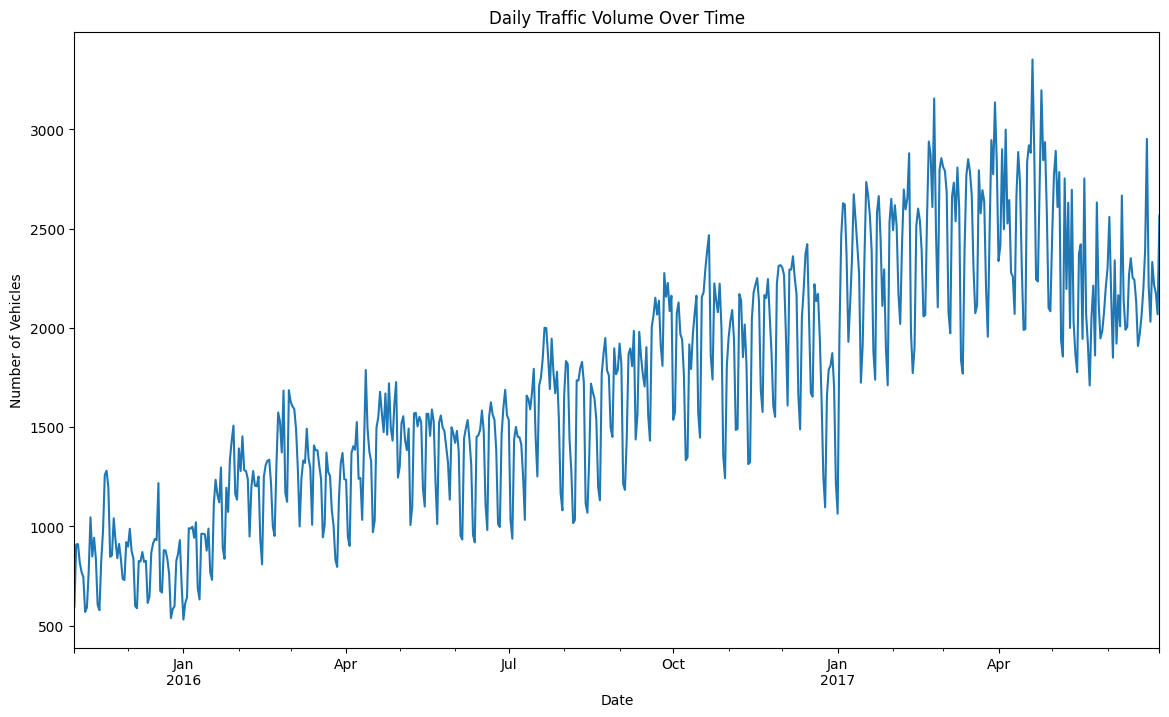

<Figure size 1400x800 with 0 Axes>

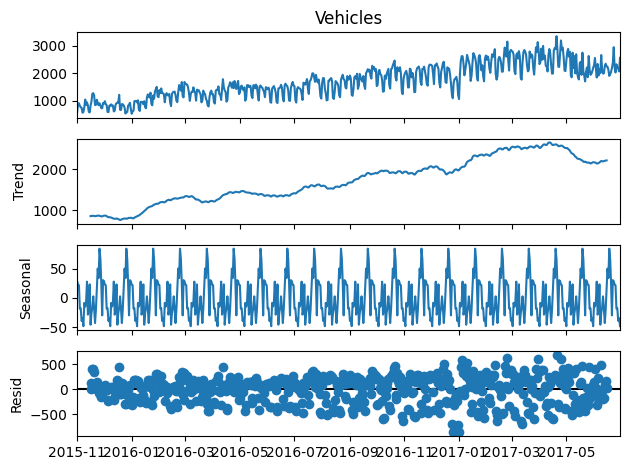

In [10]:
daily_traffic = wrangled_traffic_data.resample('D', on='DateTime')['Vehicles'].sum()

plt.figure(figsize=(14, 8))
daily_traffic.plot()
plt.title('Daily Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.show()

# Decompose time series to observe trend, seasonality, and noise
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(daily_traffic, model='additive', period=30)

plt.figure(figsize=(14, 8))
result.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


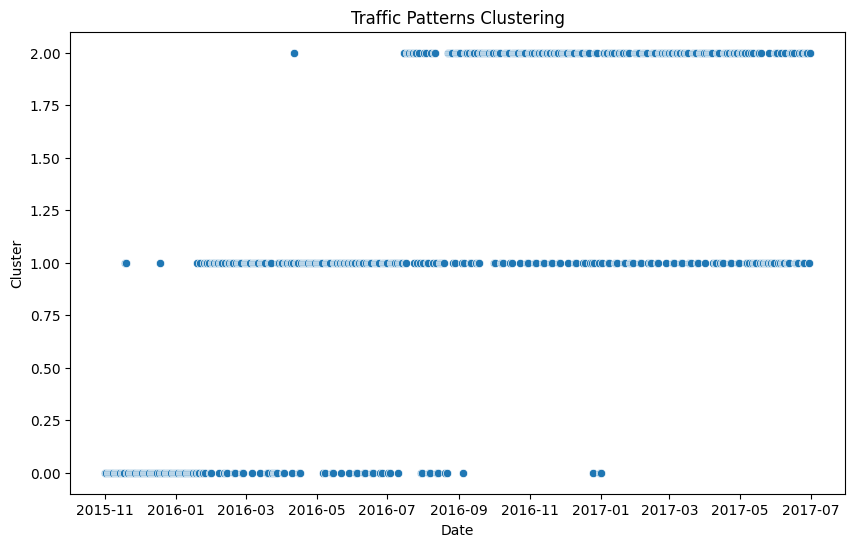

In [11]:
from sklearn.cluster import KMeans

# Reshape data for clustering
hourly_traffic = wrangled_traffic_data.pivot_table(index='date', columns='hour', values='Vehicles', aggfunc='mean').fillna(0)
kmeans = KMeans(n_clusters=3, random_state=0).fit(hourly_traffic)

# Add cluster labels to the data
hourly_traffic['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x=hourly_traffic.index, y=hourly_traffic['Cluster'])
plt.title('Traffic Patterns Clustering')
plt.xlabel('Date')
plt.ylabel('Cluster')
plt.show()

Mean Squared Error: 141.1170169157926
R^2 Score: 0.5993708177487875


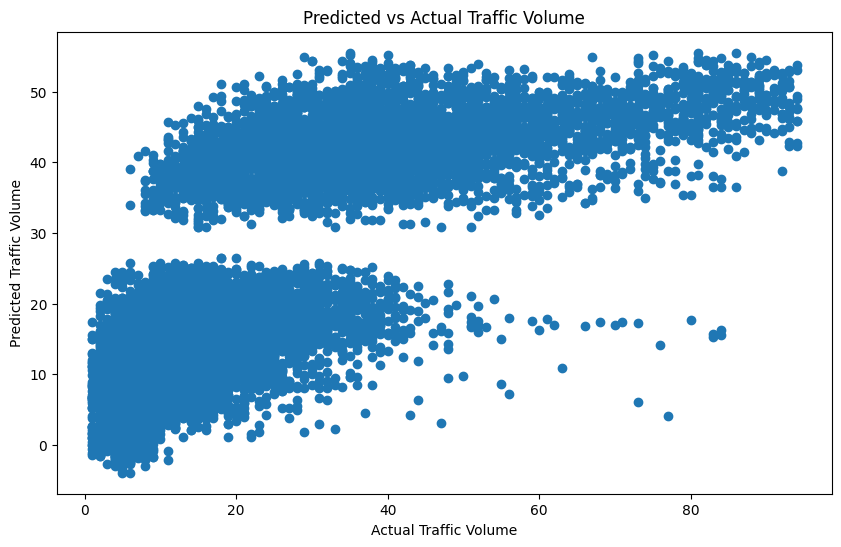

In [14]:
# Use Linear Regression to predict traffic volume
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for modeling
X = wrangled_traffic_data[['hour', 'day_of_week', 'month', 'Junction']]
X = pd.get_dummies(X, columns=['Junction'], drop_first=True)
y = wrangled_traffic_data['Vehicles']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.title('Predicted vs Actual Traffic Volume')
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Predicted Traffic Volume')
plt.show()